In [8]:
# import
import keras
import sys
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import model_selection
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
import h5py as h5py

In [9]:
BINARY = False
timestep = 1
epochs = 10
en_corpus_file = "corpus-en.txt"
ewo_corpus_file = "corpus-ewo.txt"
best_model_file = "best-model-conll.hdfs"
max_nb_of_phrases =  -1
duplication = 1
max_depth = 0
is_only_vocab = True
shuffle = is_only_vocab
h1_size = 640
h2_size = 160

In [10]:
def getTag(aString):
    tag = "O"
    if BINARY:
        if aString != "O":
            return "NE"
    else:
        tag = aString
    return tag
     

In [11]:
def load_corpus(file, max_nb_of_phrases):
    nb_of_phrases = 0
    dataset = {"word": [], "ne-tag": []}
    with open(file) as f:
        prev_line = None
        for cpt, line in enumerate(f):
            if cpt == 0:
                continue
            if nb_of_phrases == max_nb_of_phrases:
                break;

            l = line.strip()
            if len(l) == 0 and len(prev_line) != 0:
                nb_of_phrases += 1
                dataset["word"].append(line)
                dataset["ne-tag"].append(None)
            else:
                l = l.split("\t")
                if l[0] not in string.punctuation:
                    dataset["word"].append(l[0])
                    dataset["ne-tag"].append(ne_type(l[1]))
            prev_line = line.strip()
        
    return pd.DataFrame(dataset), nb_of_phrases+1

In [12]:
def corpus_fingerprint(aDataframe, nb_of_biphrases):
    # create distributionnal signature
    fingerprints = {}
    current_bi_phrase_index = 0
    nb_word_in_corpus = aDataframe[aDataframe.word != "\n"].word.size
    words_in_current_phrase = []
    for index, row in aDataframe.iterrows():
        if current_bi_phrase_index > nb_of_biphrases:
            break
            
        word = row['word']
        
        if word != "\n":
            words_in_current_phrase.append(word)
            if word not in fingerprints:
                fingerprints[word] = np.zeros(nb_of_biphrases, dtype=np.float32)
            fingerprints[word][current_bi_phrase_index] += 1
        else:
            nb_word_in_current_phrase = len(words_in_current_phrase)
#             for w in words_in_current_phrase:
#                 fingerprints[w][current_bi_phrase_index] = nb_word_in_corpus / fingerprints[w][current_bi_phrase_index]                
            current_bi_phrase_index += 1
            words_in_current_phrase = []
    for word in fingerprints:
        for i in range(nb_of_biphrases):
            if fingerprints[word][i] != 0:
                fingerprints[word][i] = nb_word_in_corpus / fingerprints[word][i]
#         fingerprints[word][nb_of_biphrases] = nb_word_in_corpus / aDataframe[aDataframe.word == word].word.size
        
    return pd.DataFrame(fingerprints)

In [13]:
def corpus2trainingdata(aDataframe, fingerprintsDataFrame):
    X = np.zeros((aDataframe.shape[0], fingerprintsDataFrame.shape[0]), dtype=np.int8)
    y = np.zeros(aDataframe.shape[0], dtype=np.int8)
    i = 0
    for row in aDataframe.iterrows():
        X[i] = fingerprintsDataFrame[row[1]['word']].values
        y[i] = tag2int[getTag(row[1]['ne-tag'])]
        i += 1
    return X, y

In [14]:
def train_test_split(X, y, test_size = 0.33):
    total = X.shape[0]
    train_length = round(total * (1 - test_size)) 
    return X[:train_length], X[train_length:], y[:train_length], y[train_length:]

In [15]:
  
def ne_type(aType):
    aType = aType.lower()
    if 'per' in aType:
        t =  'NE' if BINARY else 'PER' 
    elif 'loc' in aType:
        t =  'NE' if BINARY else 'LOC'
    elif 'org' in aType:
        t =  'NE' if BINARY else 'ORG'
    elif 'hour' in aType:
        t =  'NE' if BINARY else 'MISC'
    elif aType != 'o' and len(aType) > 0 :
        t =  'NE' if BINARY else 'MISC'
    else:
        t = 'O'
    return t

In [16]:
def compute_performance(y_true, y_pred, words=None, BINARY=False):
    if BINARY:
        p = precision_score(y_true, y_pred, pos_label=tag2int['NE'])
        r = recall_score(y_true, y_pred, pos_label=tag2int['NE'])
        f1 = f1_score(y_true, y_pred, pos_label=tag2int['NE'])
        acc = accuracy_score(y_true, y_pred)
    else:
        p = precision_score(y_pred, y_true, average='macro')
        r = recall_score(y_pred, y_true, average='macro')
        f1 = f1_score(y_pred, y_true, average='macro')
        acc = accuracy_score(y_pred, y_true)
    if words is None:
        model_output_vs = pd.DataFrame({'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})
    else:
        model_output_vs = pd.DataFrame({'word': words, 'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})

    return p, r, f1, acc, model_output_vs

In [17]:
def P_R_F1(y_pred, y_true, neg_class):
    same = y_pred[y_true==y_pred]
    tp = same[same != neg_class].size
    nb_of_pos_exple = y_true[y_true != neg_class].size
    nb_of_pos_pred = y_pred[y_pred != neg_class].size
    p = r = f1 = 0
    try:
        p = np.round(tp*100/nb_of_pos_pred, 2)
    except ZeroDivisionError:
        print("number of correct positive predictions is 0")
        
    try:
        r = np.round(tp*100/nb_of_pos_exple, 2)
    except ZeroDivisionError:
        print("number of position exple is 0")
        
    try:
        f1 = np.round(2*r*p/(r+p), 2)
    except ZeroDivisionError:
        print("Recall and precision are 0")

    return p, r, f1

In [18]:
def is_mergeable(aListOfConsecutiveTokens, corpus, fingerprints):
    n = len(aListOfConsecutiveTokens)
    if n <= 1:
        return False
    if n == 2:
        w1, w2 = aListOfConsecutiveTokens[0], aListOfConsecutiveTokens[1]
        rep1, rep2 = fingerprints[aListOfConsecutiveTokens[0]], fingerprints[aListOfConsecutiveTokens[1]]
        tag1, tag2 = corpus[corpus.word==w1].iloc[0]['ne-tag'], corpus[corpus.word==w2].iloc[0]['ne-tag']
        if (tag1 == tag2) and (tag1 == "O"): # O + O => False
            return False
        if (tag1 != tag2) and (tag1 != "O") and (tag2 != "O"): # X + Y => False
            return False
        return rep1.equals(rep2)
    else:
        half = int(n / 2)
        return is_mergeable(aListOfConsecutiveTokens[0:half+1], corpus, fingerprints) and is_mergeable(aListOfConsecutiveTokens[half:n], corpus, fingerprints)

In [19]:
def merge(depth, corpus, fingerprint):
    wordDf = corpus[corpus.word != "\n"].word
    nbOfWord = wordDf.shape[0]
    text = list(wordDf)
    X2, target2, tokens = [], [], []
    level, newToken = 1, True
    while level <= depth and newToken:
        i, newToken = 0, False
        limit = nbOfWord - level
        while i < limit:
            if is_mergeable(text[i:i+level+1], corpus, fingerprint):
                tokens.append(" ".join(text[i:i+level+1]))
                newToken = True
            i += 1
        print("level ", level, ":", set(tokens))
        level += 1
    
    X2, target2 = np.array(X2), np.array(target2)
    
    return X2, target2, set(tokens)

In [20]:
def shuffle(X, y):
    indices = [i for i in  range(X.shape[0])]
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [21]:
def create_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(h1_size, input_dim=input_dim, activation='sigmoid', name="hidden1"))
    model.add(Dense(h2_size, activation='sigmoid', name="hidden2"))
    if BINARY:
        model.add(Dense(1, activation='sigmoid', name="outputlayer"))
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
    else:
        model.add(Dense(output_dim, activation='softmax', name="outputlayer"))
        model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    model.summary()
    return model

In [22]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=epochs):
    early_stop = EarlyStopping(patience=20, verbose=2) # stop learning if the error is the same between two consecutive epochs
    best_model_cp = ModelCheckpoint(best_model_file, save_best_only=True, verbose=1) # saved best model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0, shuffle=shuffle, callbacks=[best_model_cp, early_stop])
    best_model = keras.models.load_model(best_model_file) #loading the best model
    return best_model

In [23]:
def predict(model, X, y, binary=BINARY):
    if BINARY:
        y_pred = np.round(model.predict(X))
        y_true = y
    else:
        predictions = model.predict(X)
        y_pred = np.array([np.argmax(p) for p in predictions])
        y_true = np.array([np.argmax(t) for t in y ])
    return y_true, y_pred

In [24]:
def model_performance(y_true, y_pred):
    return P_R_F1(y_pred, y_true, tag2int['O']) #precision, recall, f1-score

In [25]:
def model_performace_by_tag(y_true, y_pred, tag):
    p, r, f1 = 0, 0, 0
    
    eq = y_pred[y_pred==y_true]
    correctly_pred = eq[eq==tag].size
    try:
        p = np.round(100 * correctly_pred / y_pred[y_pred==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        r = np.round(100 * correctly_pred / y_true[y_true==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        f1 = np.round(2 * r * p / (r + p), 2)
    except ZeroDivisionError:
        pass
    
    return p, r, f1

In [26]:
def algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, epochs=epochs, model=None):
    test_precision, train_precision, ewo_precision = [], [], []
    test_recall, train_recall, ewo_recall = [], [], []
    test_fscore, train_fscore, ewo_fscore = [], [], []
    
    test_result_by_tag = {}
    train_result_by_tag = {}
    ewo_result_by_tag = {}
    for t in tagSet:
        f1_key = "F1-"+t
        p_key = "P-"+t
        r_key = "R-"+t
        train_result_by_tag[f1_key], train_result_by_tag[p_key], train_result_by_tag[r_key] = [], [], []
        test_result_by_tag[f1_key], test_result_by_tag[p_key], test_result_by_tag[r_key] = [], [], []
        ewo_result_by_tag[f1_key], ewo_result_by_tag[p_key], ewo_result_by_tag[r_key] = [], [], []

    m = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        
    y_true, y_pred = predict(m, X_train, y_train)
    p_train, r_train, f1_train = model_performance(y_true, y_pred)
        
    y_true_val, y_pred_val = predict(m, X_val, y_val)
    p_val, r_val, f1_val = model_performance(y_true_val, y_pred_val)
        
    y_true_ewo, y_pred_ewo = predict(m, X_ewo, y_ewo) 
    p_ewo, r_ewo, f1_ewo = model_performance(y_true_ewo, y_pred_ewo)
        
    for t in range(len(int2tag)):
        f1_key = "F1-" + int2tag[t]
        p_key = "P-" + int2tag[t]
        r_key = "R-" + int2tag[t]
            
        p, r, f1 = model_performace_by_tag(y_true, y_pred, t)
        train_result_by_tag[p_key].append(p)
        train_result_by_tag[r_key].append(r)
        train_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_val, y_pred_val, t)
        test_result_by_tag[p_key].append(p)
        test_result_by_tag[r_key].append(r)
        test_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_ewo, y_pred_ewo, t)
        ewo_result_by_tag[p_key].append(p)
        ewo_result_by_tag[r_key].append(r)
        ewo_result_by_tag[f1_key].append(f1)
                
    test_precision.append(p_val)
    train_precision.append(p_train)
    ewo_precision.append(p_ewo)
        
    test_recall.append(r_val)
    train_recall.append(r_train)
    ewo_recall.append(r_ewo)
        
    test_fscore.append(f1_val)
    train_fscore.append(f1_train)
    ewo_fscore.append(f1_ewo)
    return pd.DataFrame({
        'P_test': test_precision, 
        'P_train': train_precision, 
        'P_ewo': ewo_precision, 'R_test': test_recall, 'R_train': train_recall, 
        'R_ewo': ewo_recall, 'F1-test': test_fscore, 'F1-train': train_fscore, 'F1-ewo': ewo_fscore}), pd.DataFrame(train_result_by_tag), pd.DataFrame(test_result_by_tag), pd.DataFrame(ewo_result_by_tag)

In [27]:
def algoCrossVal(X, y, X_ewo, y_ewo, k = 10, repeat=1): 
    block_size = int(X.shape[0] / k)   
    output = None
    model = None
    train_by_tags, test_by_tags, ewo_by_tags = None, None, None
    for it in range(repeat):
        print("AlgoCrossValIter -", it+1)
        model = create_model(X.shape[1], len(tagSet))
        results = None
        train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = None, None, None
        for i in range(k):
            X_val, y_val = X[i*block_size:i*block_size+block_size], y[i*block_size:i*block_size+block_size]
            X_train = np.concatenate((X[0:i*block_size], X[i*block_size+block_size:]))
            y_train = np.concatenate((y[0:i*block_size], y[i*block_size+block_size:]))

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
            X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])

            result, train_by_tag, test_by_tag, ewo_by_tag = algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, model=model)
            if results is None:
                results = result.copy()
                train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = train_by_tag.copy(), test_by_tag.copy(), ewo_by_tag.copy()
            else:
                results = pd.concat([results, result], ignore_index=True)
                train_by_tagsTmp = pd.concat([train_by_tagsTmp, train_by_tag], ignore_index=True)
                test_by_tagsTmp = pd.concat([test_by_tagsTmp, test_by_tag], ignore_index=True)
                ewo_by_tagsTmp = pd.concat([ewo_by_tagsTmp, ewo_by_tag], ignore_index=True)
        
        if output is None:
            output = results.mean(axis=0).to_frame()
            train_by_tags = train_by_tagsTmp.mean(axis=0).to_frame()
            test_by_tags = test_by_tagsTmp.mean(axis=0).to_frame()
            ewo_by_tags = ewo_by_tagsTmp.mean(axis=0).to_frame()
        else:
            output = pd.concat([output, results.mean(axis=0).to_frame()], axis=1)
            train_by_tags = pd.concat([train_by_tags, train_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            test_by_tags = pd.concat([test_by_tags, test_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            ewo_by_tags = pd.concat([ewo_by_tags, ewo_by_tagsTmp.mean(axis=0).to_frame()], axis=1)

    return output, train_by_tags, test_by_tags, ewo_by_tags, model

In [28]:
en_corpus, en_nb_of_phrases = load_corpus(en_corpus_file, max_nb_of_phrases)

In [29]:
en_corpus.head()
en_corpus.loc[en_corpus['ne-tag'] == 'ORG']

,word,ne-tag
1335,Sadducees,ORG


In [30]:
tagSet = en_corpus["ne-tag"].dropna().unique()
if BINARY:
    tagSet = ['NE', 'O']
tag2int = {j: i for i, j in enumerate(tagSet)}
int2tag = {i: j for i, j in enumerate(tagSet)}
print(tag2int)

{'O': 0, 'MISC': 1, 'PER': 2, 'LOC': 3, 'ORG': 4}


In [31]:
en_nb_of_phrases

210

In [32]:
en_corpus.describe()

,word,ne-tag
count,4379,4170
unique,904,5
top,the,O
freq,313,3779


In [33]:
en_corpus.head(10)

,word,ne-tag
0,The,O
1,Promise,O
2,of,O
3,the,O
4,Holy,MISC
5,Spirit,MISC
6,\n,None
7,In,O
8,the,O
9,first,O


In [34]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 86.3 %
MISC % = 2.4 %
PER % = 5.59 %
LOC % = 0.91 %
ORG % = 0.02 %


In [35]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 89.16 %
MISC % = 1.88 %
PER % = 8.96 %
LOC % = 1.99 %
ORG % = 0.11 %


In [36]:
en_corpus[en_corpus.word == "\n"].shape

(209, 2)

In [37]:
print("Nb of bi-phrases", en_nb_of_phrases)
en_fingerprints = corpus_fingerprint(en_corpus, en_nb_of_phrases)

Nb of bi-phrases 210


In [38]:
en_fingerprints.head(5)

,The,Promise,of,the,Holy,Spirit,In,first,book,O,...,considered,dream,She,save,fulfill,Immanuel,us),woke,sleep,knew
0,4170.0,4170.0,4170.0,4170.0,4170.0,4170.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,4170.0,0.0,0.0,4170.0,4170.0,4170.0,4170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1390.0,4170.0,4170.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,4170.0,4170.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4170.0,2085.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
en_fingerprints['you'].values.shape

(210,)

In [40]:
en_corpus[en_corpus.word != "\n"].shape

(4170, 2)

In [41]:
X2, target2, tokens = merge(max_depth, en_corpus, en_fingerprints)

In [42]:
if is_only_vocab:
    text = list(en_corpus[en_corpus.word != "\n"].word.unique())
else:
    text = list(en_corpus[en_corpus.word != "\n"].word)
en_vocab = pd.DataFrame({'text': text + list(tokens)})
en_vocab.describe()

,text
count,903
unique,903
top,ankles
freq,1


In [43]:
if is_only_vocab:
    X = np.zeros((en_vocab.shape[0] * duplication, en_nb_of_phrases))
    target = np.zeros((en_vocab.shape[0] * duplication))
    p=0
    for i, row in en_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X[p] = en_fingerprints[c.split(" ")[0]]
            target[p] = tag2int[getTag(en_corpus[en_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X, target = shuffle(X, target)
    print(X.shape, en_fingerprints.shape, target.shape)

(903, 210) (210, 903) (903,)


In [44]:
en_vocab[-20:]

,text
883,Eliud
884,Eleazar
885,Matthan
886,husband
887,fourteen
888,unwilling
889,shame
890,resolved
891,divorce
892,quietly


In [45]:
if not is_only_vocab:
    X, target = corpus2trainingdata(en_corpus[en_corpus.word != "\n"], en_fingerprints)

In [46]:
print(X.shape, target.shape)
if len(X.shape) == len(X2.shape):
    X = np.concatenate((X, X2))
    target = np.concatenate((target, target2))
    if shuffle:
        X, target = shuffle(X, target)
print(X.shape, target.shape)

(903, 210) (903,)
(903, 210) (903,)


In [47]:
y = target.copy()
y[0:100]
if not BINARY:
    y = np_utils.to_categorical(y, len(tagSet))
y.shape

(903, 5)

In [48]:
from sklearn.decomposition import PCA

def visualize(X, y):
    pca = PCA(n_components=2)
    X_embeded = pca.fit_transform(X)
    plt.figure(figsize=(16, 16))
    plt.scatter(X_embeded[:, 0], X_embeded[:, 1], c=y)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


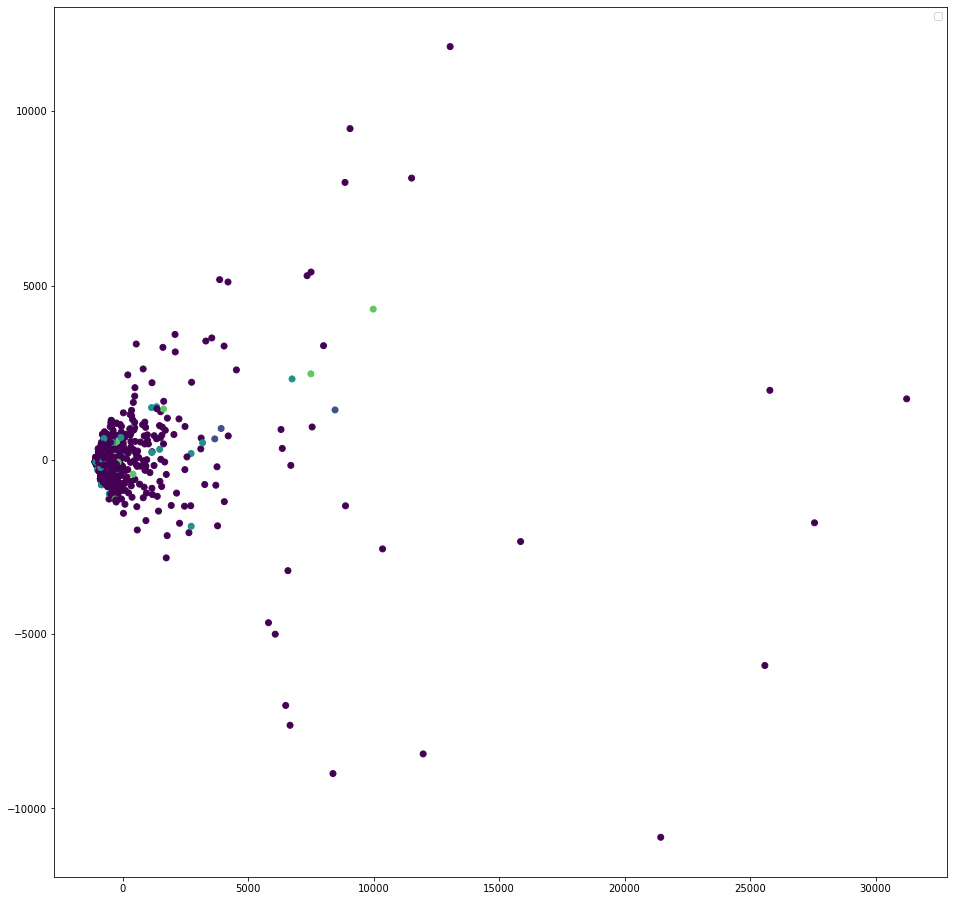

In [49]:
visualize(X, target)

In [50]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.33)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_val.shape =", X_val.shape)
print("y_val.shape =", y_val.shape)

tTarget = np.array([np.argmax(yy) for yy in y_train])
vTarget = np.array([np.argmax(yy) for yy in y_val])

for tag in tagSet:
    print("{0} % in training data = {1} %".format(tag, np.round(tTarget[tTarget==tag2int[tag]].size * 100 / tTarget.shape[0], 2)))
    print("{0} % in validation data = {1} %".format(tag, np.round(vTarget[vTarget==tag2int[tag]].size * 100 / vTarget.shape[0], 2)))

X_train.shape = (605, 210)
y_train.shape = (605, 5)
X_val.shape = (298, 210)
y_val.shape = (298, 5)
O % in training data = 86.45 %
O % in validation data = 91.95 %
MISC % in training data = 1.82 %
MISC % in validation data = 0.0 %
PER % in training data = 9.09 %
PER % in validation data = 7.38 %
LOC % in training data = 2.48 %
LOC % in validation data = 0.67 %
ORG % in training data = 0.17 %
ORG % in validation data = 0.0 %


In [51]:
ewo_corpus, ewo_nb_of_phrases = load_corpus(ewo_corpus_file, max_nb_of_phrases)

In [52]:
ewo_corpus.loc[ewo_corpus['ne-tag'] == 'PER']

,word,ne-tag
6,Teofil,PER
15,Yesus,PER
86,Yohannes,PER
104,Yesus,PER
230,Yesus,PER
...,...,...
3676,Maria,PER
3697,Yesus,PER
3740,Emmanuel,PER
3750,Yosef,PER


In [53]:
ewo_nb_of_phrases

210

In [54]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 84.15 %
MISC % = 2.54 %
PER % = 6.69 %
LOC % = 1.03 %
ORG % = 0.05 %


In [55]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 89.94 %
MISC % = 1.17 %
PER % = 8.3 %
LOC % = 1.86 %
ORG % = 0.2 %


In [56]:
ewo_corpus.describe()

,word,ne-tag
count,3779,3570
unique,1024,5
top,\n,O
freq,209,3180


In [57]:
ewo_corpus.head()

,word,ne-tag
0,Mfufub,MISC
1,Nsisim,MISC
2,ayi,O
3,sò,O
4,\n,None


In [60]:
ewo_fingerprints = corpus_fingerprint(ewo_corpus, en_nb_of_phrases)
# ewo_fingerprints = scale(ewo_fingerprints)

In [61]:
X2, target2, tokens = merge(max_depth, ewo_corpus, ewo_fingerprints)

In [62]:
if is_only_vocab:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word.unique())
else:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word)
ewo_vocab = pd.DataFrame({"text":text + list(tokens)})

In [63]:
if is_only_vocab:
    X_ewo = np.zeros((ewo_vocab.shape[0] * duplication, en_nb_of_phrases))
    ewo_target = np.zeros((ewo_vocab.shape[0] * duplication))
    p=0
    for i, row in ewo_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X_ewo[p] = ewo_fingerprints[c.split(" ")[0]]
            ewo_target[p] = tag2int[getTag(ewo_corpus[ewo_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X_ewo, ewo_target = shuffle(X_ewo, ewo_target)

In [64]:
ewo_vocab[-20:]

,text
1003,nlo
1004,obë
1005,mbara
1006,yabyali
1007,dzili
1008,yasò
1009,oyolëge
1010,kode
1011,dili
1012,atoban


In [65]:
if not is_only_vocab:
    X_ewo, ewo_target = corpus2trainingdata(ewo_corpus[ewo_corpus.word != "\n"], ewo_fingerprints)

In [66]:
print(X_ewo.shape, ewo_target.shape)
if len(X_ewo.shape) == len(X2.shape):
    X_ewo = np.concatenate((X_ewo, X2))
    ewo_target = np.concatenate((ewo_target, target2))
    if shuffle:
        X_ewo, ewo_target = shuffle(X_ewo, ewo_target)
print(X_ewo.shape, ewo_target.shape)

(1023, 210) (1023,)
(1023, 210) (1023,)


In [67]:
y_ewo = ewo_target.copy()
print(y_ewo.shape, len(ewo_vocab))

(1023,) 1023


In [68]:
X_ewo.shape

(1023, 210)

In [69]:
y_ewo = ewo_target.copy()
y_ewo[:20]
if not BINARY:
    y_ewo = np_utils.to_categorical(y_ewo)

In [70]:
X_ewo = X_ewo.reshape((X_ewo.shape[0], en_nb_of_phrases))

In [71]:
# model = create_model(X.shape[1], len(tagSet))
# resultEval, train_by_tag, test_by_tag, ewo_by_tag = algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, model=model)

In [72]:
# resultEval

In [73]:
# train_by_tag

In [74]:
# test_by_tag

In [75]:
# ewo_by_tag

In [76]:
# resultEval.mean()

In [77]:
# resultEval.std()

In [78]:
resultCrossVal, trainByTagResult, testByTagResult, ewoByTagResult, model = algoCrossVal(X, y, X_ewo, y_ewo, repeat=10)

AlgoCrossValIter - 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.48232, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.48232 to 0.43519, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.43519

Epoch 00004: val_loss improved from 0.43519 to 0.27011, saving model to best-model-conll.hdfs

Epoch 00005: val_loss d

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10737, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10737

Epoch 00003: val_loss did not improve from 0.10737

Epoch 00004: val_loss did not improve from 0.10737

Epoch 00005: val_loss did not improve from 0.10737

Epoch 00006: val_loss did not improve from 0.10737

Epoch 00007: val_loss did not improve from 0.10737

Epoch 00008: val_loss did not improve from 0.10737

Epoch 00009: val_loss did not improve from 0.10737

Epoch 00010: val_loss did not improve from 0.10737


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07690, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.07690 to 0.06554, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.06554

Epoch 00004: val_loss did not improve from 0.06554

Epoch 00005: val_loss did not improve from 0.06554

Epoch 00006: val_loss did not improve from 0.06554

Epoch 00007: val_loss did not improve from 0.06554

Epoch 00008: val_loss did not improve from 0.06554

Epoch 00009: val_loss did not improve from 0.06554

Epoch 00010: val_loss did not improve from 0.06554


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10763, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10763

Epoch 00003: val_loss did not improve from 0.10763

Epoch 00004: val_loss did not improve from 0.10763

Epoch 00005: val_loss did not improve from 0.10763

Epoch 00006: val_loss did not improve from 0.10763

Epoch 00007: val_loss did not improve from 0.10763

Epoch 00008: val_loss did not improve from 0.10763

Epoch 00009: val_loss did not improve from 0.10763

Epoch 00010: val_loss did not improve from 0.10763


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07003, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07003

Epoch 00003: val_loss did not improve from 0.07003

Epoch 00004: val_loss did not improve from 0.07003

Epoch 00005: val_loss did not improve from 0.07003

Epoch 00006: val_loss did not improve from 0.07003

Epoch 00007: val_loss did not improve from 0.07003

Epoch 00008: val_loss did not improve from 0.07003

Epoch 00009: val_loss did not improve from 0.07003

Epoch 00010: val_loss did not improve from 0.07003


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06693, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06693

Epoch 00003: val_loss did not improve from 0.06693

Epoch 00004: val_loss did not improve from 0.06693

Epoch 00005: val_loss did not improve from 0.06693

Epoch 00006: val_loss did not improve from 0.06693

Epoch 00007: val_loss did not improve from 0.06693

Epoch 00008: val_loss did not improve from 0.06693

Epoch 00009: val_loss did not improve from 0.06693

Epoch 00010: val_loss did not improve from 0.06693


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07436, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07436

Epoch 00003: val_loss did not improve from 0.07436

Epoch 00004: val_loss improved from 0.07436 to 0.07013, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.07013

Epoch 00006: val_loss did not improve from 0.07013

Epoch 00007: val_loss did not improve from 0.07013

Epoch 00008: val_loss did not improve from 0.07013

Epoch 00009: val_loss did not improve from 0.07013

Epoch 00010: val_loss did not improve from 0.07013


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05042, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05042

Epoch 00003: val_loss did not improve from 0.05042

Epoch 00004: val_loss did not improve from 0.05042

Epoch 00005: val_loss did not improve from 0.05042

Epoch 00006: val_loss did not improve from 0.05042

Epoch 00007: val_loss did not improve from 0.05042

Epoch 00008: val_loss did not improve from 0.05042

Epoch 00009: val_loss did not improve from 0.05042

Epoch 00010: val_loss did not improve from 0.05042


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10654, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10654

Epoch 00003: val_loss did not improve from 0.10654

Epoch 00004: val_loss did not improve from 0.10654

Epoch 00005: val_loss did not improve from 0.10654

Epoch 00006: val_loss did not improve from 0.10654

Epoch 00007: val_loss did not improve from 0.10654

Epoch 00008: val_loss did not improve from 0.10654

Epoch 00009: val_loss did not improve from 0.10654

Epoch 00010: val_loss did not improve from 0.10654


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08527, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08527

Epoch 00003: val_loss did not improve from 0.08527

Epoch 00004: val_loss did not improve from 0.08527

Epoch 00005: val_loss did not improve from 0.08527

Epoch 00006: val_loss did not improve from 0.08527

Epoch 00007: val_loss did not improve from 0.08527

Epoch 00008: val_loss did not improve from 0.08527

Epoch 00009: val_loss did not improve from 0.08527

Epoch 00010: val_loss did not improve from 0.08527


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.40605, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.40605 to 0.33286, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.33286 to 0.28939, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.28939 to 0.26902, saving model to bes

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.14331, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.14331 to 0.11482, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.11482

Epoch 00004: val_loss did not improve from 0.11482

Epoch 00005: val_loss did not improve from 0.11482

Epoch 00006: val_loss did not improve from 0.11482

Epoch 00007: val_loss did not improve from 0.11482

Epoch 00008: val_loss did not improve from 0.11482

Epoch 00009: val_loss did not improve from 0.11482

Epoch 00010: val_loss did not improve from 0.11482


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05452, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05452

Epoch 00003: val_loss did not improve from 0.05452

Epoch 00004: val_loss did not improve from 0.05452

Epoch 00005: val_loss did not improve from 0.05452

Epoch 00006: val_loss did not improve from 0.05452

Epoch 00007: val_loss did not improve from 0.05452

Epoch 00008: val_loss did not improve from 0.05452

Epoch 00009: val_loss did not improve from 0.05452

Epoch 00010: val_loss did not improve from 0.05452

Epoch 00001: val_loss improved from inf to 0.14259, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.14259 to 0.10491, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.10491

Epoch 00004: val_loss did not improve from 0.10491

Epoch 00005: val_loss did not improve from 0.10491

Epoch 00006: val_loss did not improve from 0.10491

Epoch 00007: val_loss did not improve from 0.1

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07564, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07564

Epoch 00003: val_loss did not improve from 0.07564

Epoch 00004: val_loss did not improve from 0.07564

Epoch 00005: val_loss did not improve from 0.07564

Epoch 00006: val_loss did not improve from 0.07564

Epoch 00007: val_loss did not improve from 0.07564

Epoch 00008: val_loss did not improve from 0.07564

Epoch 00009: val_loss did not improve from 0.07564

Epoch 00010: val_loss did not improve from 0.07564


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08348, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08348

Epoch 00003: val_loss improved from 0.08348 to 0.07756, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.07756

Epoch 00005: val_loss did not improve from 0.07756

Epoch 00006: val_loss did not improve from 0.07756

Epoch 00007: val_loss did not improve from 0.07756

Epoch 00008: val_loss did not improve from 0.07756

Epoch 00009: val_loss did not improve from 0.07756

Epoch 00010: val_loss did not improve from 0.07756


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07770, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.07770 to 0.07005, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.07005 to 0.05953, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.05953

Epoch 00005: val_loss did not improve from 0.05953

Epoch 00006: val_loss did not improve from 0.05953

Epoch 00007: val_loss did not improve from 0.05953

Epoch 00008: val_loss did not improve from 0.05953

Epoch 00009: val_loss did not improve from 0.05953

Epoch 00010: val_loss did not improve from 0.05953


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05562, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05562

Epoch 00003: val_loss did not improve from 0.05562

Epoch 00004: val_loss did not improve from 0.05562

Epoch 00005: val_loss did not improve from 0.05562

Epoch 00006: val_loss did not improve from 0.05562

Epoch 00007: val_loss did not improve from 0.05562

Epoch 00008: val_loss did not improve from 0.05562

Epoch 00009: val_loss did not improve from 0.05562

Epoch 00010: val_loss did not improve from 0.05562


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.11288, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.11288

Epoch 00003: val_loss did not improve from 0.11288

Epoch 00004: val_loss did not improve from 0.11288

Epoch 00005: val_loss did not improve from 0.11288

Epoch 00006: val_loss did not improve from 0.11288

Epoch 00007: val_loss did not improve from 0.11288

Epoch 00008: val_loss did not improve from 0.11288

Epoch 00009: val_loss did not improve from 0.11288

Epoch 00010: val_loss did not improve from 0.11288


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07106, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07106

Epoch 00003: val_loss did not improve from 0.07106

Epoch 00004: val_loss did not improve from 0.07106

Epoch 00005: val_loss did not improve from 0.07106

Epoch 00006: val_loss did not improve from 0.07106

Epoch 00007: val_loss did not improve from 0.07106

Epoch 00008: val_loss did not improve from 0.07106

Epoch 00009: val_loss did not improve from 0.07106

Epoch 00010: val_loss did not improve from 0.07106


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 3
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.42199, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.42199 to 0.38146, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.38146 to 0.32880, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.32880

Epoch 00005: val_loss d

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12575, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.12575 to 0.09096, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.09096

Epoch 00004: val_loss did not improve from 0.09096

Epoch 00005: val_loss did not improve from 0.09096

Epoch 00006: val_loss did not improve from 0.09096

Epoch 00007: val_loss did not improve from 0.09096

Epoch 00008: val_loss did not improve from 0.09096

Epoch 00009: val_loss did not improve from 0.09096

Epoch 00010: val_loss did not improve from 0.09096


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06026, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06026

Epoch 00003: val_loss did not improve from 0.06026

Epoch 00004: val_loss did not improve from 0.06026

Epoch 00005: val_loss did not improve from 0.06026

Epoch 00006: val_loss did not improve from 0.06026

Epoch 00007: val_loss did not improve from 0.06026

Epoch 00008: val_loss did not improve from 0.06026

Epoch 00009: val_loss did not improve from 0.06026

Epoch 00010: val_loss did not improve from 0.06026


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.13311, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.13311 to 0.11256, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.11256

Epoch 00004: val_loss did not improve from 0.11256

Epoch 00005: val_loss did not improve from 0.11256

Epoch 00006: val_loss did not improve from 0.11256

Epoch 00007: val_loss did not improve from 0.11256

Epoch 00008: val_loss did not improve from 0.11256

Epoch 00009: val_loss did not improve from 0.11256

Epoch 00010: val_loss did not improve from 0.11256


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.16189, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.16189 to 0.10563, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.10563 to 0.08903, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.08903

Epoch 00005: val_loss did not improve from 0.08903

Epoch 00006: val_loss did not improve from 0.08903

Epoch 00007: val_loss did not improve from 0.08903

Epoch 00008: val_loss did not improve from 0.08903

Epoch 00009: val_loss did not improve from 0.08903

Epoch 00010: val_loss did not improve from 0.08903


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06667, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06667

Epoch 00003: val_loss did not improve from 0.06667

Epoch 00004: val_loss did not improve from 0.06667

Epoch 00005: val_loss did not improve from 0.06667

Epoch 00006: val_loss did not improve from 0.06667

Epoch 00007: val_loss did not improve from 0.06667

Epoch 00008: val_loss did not improve from 0.06667

Epoch 00009: val_loss did not improve from 0.06667

Epoch 00010: val_loss did not improve from 0.06667

Epoch 00001: val_loss improved from inf to 0.08885, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.08885 to 0.07142, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07142

Epoch 00004: val_loss did not improve from 0.07142

Epoch 00005: val_loss did not improve from 0.07142

Epoch 00006: val_loss did not improve from 0.07142

Epoch 00007: val_loss did not improve from 0.0

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07646, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07646

Epoch 00003: val_loss did not improve from 0.07646

Epoch 00004: val_loss did not improve from 0.07646

Epoch 00005: val_loss did not improve from 0.07646

Epoch 00006: val_loss did not improve from 0.07646

Epoch 00007: val_loss did not improve from 0.07646

Epoch 00008: val_loss did not improve from 0.07646

Epoch 00009: val_loss did not improve from 0.07646

Epoch 00010: val_loss did not improve from 0.07646


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10680, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10680

Epoch 00003: val_loss did not improve from 0.10680

Epoch 00004: val_loss did not improve from 0.10680

Epoch 00005: val_loss did not improve from 0.10680

Epoch 00006: val_loss did not improve from 0.10680

Epoch 00007: val_loss did not improve from 0.10680

Epoch 00008: val_loss did not improve from 0.10680

Epoch 00009: val_loss did not improve from 0.10680

Epoch 00010: val_loss did not improve from 0.10680


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07045, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.07045 to 0.07041, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07041

Epoch 00004: val_loss did not improve from 0.07041

Epoch 00005: val_loss did not improve from 0.07041

Epoch 00006: val_loss did not improve from 0.07041

Epoch 00007: val_loss did not improve from 0.07041

Epoch 00008: val_loss did not improve from 0.07041

Epoch 00009: val_loss did not improve from 0.07041

Epoch 00010: val_loss did not improve from 0.07041


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.41157, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.41157 to 0.33237, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.33237

Epoch 00004: val_loss improved from 0.33237 to 0.31069, saving model to best-model-conll.hdfs

Epoch 00005: val_loss d

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09326, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09326

Epoch 00003: val_loss did not improve from 0.09326

Epoch 00004: val_loss did not improve from 0.09326

Epoch 00005: val_loss did not improve from 0.09326

Epoch 00006: val_loss did not improve from 0.09326

Epoch 00007: val_loss did not improve from 0.09326

Epoch 00008: val_loss did not improve from 0.09326

Epoch 00009: val_loss did not improve from 0.09326

Epoch 00010: val_loss did not improve from 0.09326


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08002, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08002

Epoch 00003: val_loss did not improve from 0.08002

Epoch 00004: val_loss did not improve from 0.08002

Epoch 00005: val_loss did not improve from 0.08002

Epoch 00006: val_loss did not improve from 0.08002

Epoch 00007: val_loss did not improve from 0.08002

Epoch 00008: val_loss did not improve from 0.08002

Epoch 00009: val_loss did not improve from 0.08002

Epoch 00010: val_loss did not improve from 0.08002


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.13950, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.13950 to 0.13124, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.13124

Epoch 00004: val_loss did not improve from 0.13124

Epoch 00005: val_loss improved from 0.13124 to 0.12790, saving model to best-model-conll.hdfs

Epoch 00006: val_loss did not improve from 0.12790

Epoch 00007: val_loss did not improve from 0.12790

Epoch 00008: val_loss did not improve from 0.12790

Epoch 00009: val_loss did not improve from 0.12790

Epoch 00010: val_loss did not improve from 0.12790


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06216, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06216

Epoch 00003: val_loss did not improve from 0.06216

Epoch 00004: val_loss did not improve from 0.06216

Epoch 00005: val_loss did not improve from 0.06216

Epoch 00006: val_loss did not improve from 0.06216

Epoch 00007: val_loss did not improve from 0.06216

Epoch 00008: val_loss did not improve from 0.06216

Epoch 00009: val_loss did not improve from 0.06216

Epoch 00010: val_loss did not improve from 0.06216


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07601, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.07601 to 0.07301, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07301

Epoch 00004: val_loss did not improve from 0.07301

Epoch 00005: val_loss did not improve from 0.07301

Epoch 00006: val_loss did not improve from 0.07301

Epoch 00007: val_loss did not improve from 0.07301

Epoch 00008: val_loss did not improve from 0.07301

Epoch 00009: val_loss did not improve from 0.07301

Epoch 00010: val_loss did not improve from 0.07301


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05854, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05854

Epoch 00003: val_loss did not improve from 0.05854

Epoch 00004: val_loss did not improve from 0.05854

Epoch 00005: val_loss did not improve from 0.05854

Epoch 00006: val_loss did not improve from 0.05854

Epoch 00007: val_loss did not improve from 0.05854

Epoch 00008: val_loss did not improve from 0.05854

Epoch 00009: val_loss did not improve from 0.05854

Epoch 00010: val_loss did not improve from 0.05854


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05267, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05267

Epoch 00003: val_loss did not improve from 0.05267

Epoch 00004: val_loss did not improve from 0.05267

Epoch 00005: val_loss did not improve from 0.05267

Epoch 00006: val_loss did not improve from 0.05267

Epoch 00007: val_loss did not improve from 0.05267

Epoch 00008: val_loss did not improve from 0.05267

Epoch 00009: val_loss did not improve from 0.05267

Epoch 00010: val_loss did not improve from 0.05267


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09794, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09794

Epoch 00003: val_loss did not improve from 0.09794

Epoch 00004: val_loss did not improve from 0.09794

Epoch 00005: val_loss did not improve from 0.09794

Epoch 00006: val_loss did not improve from 0.09794

Epoch 00007: val_loss did not improve from 0.09794

Epoch 00008: val_loss did not improve from 0.09794

Epoch 00009: val_loss did not improve from 0.09794

Epoch 00010: val_loss did not improve from 0.09794


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07225, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07225

Epoch 00003: val_loss did not improve from 0.07225

Epoch 00004: val_loss did not improve from 0.07225

Epoch 00005: val_loss did not improve from 0.07225

Epoch 00006: val_loss did not improve from 0.07225

Epoch 00007: val_loss did not improve from 0.07225

Epoch 00008: val_loss did not improve from 0.07225

Epoch 00009: val_loss did not improve from 0.07225

Epoch 00010: val_loss did not improve from 0.07225


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 5
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.39574, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.39574 to 0.33818, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.33818 to 0.33036, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.33036 to 0.30727, saving model to bes

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10017, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10017

Epoch 00003: val_loss did not improve from 0.10017

Epoch 00004: val_loss did not improve from 0.10017

Epoch 00005: val_loss did not improve from 0.10017

Epoch 00006: val_loss did not improve from 0.10017

Epoch 00007: val_loss did not improve from 0.10017

Epoch 00008: val_loss did not improve from 0.10017

Epoch 00009: val_loss did not improve from 0.10017

Epoch 00010: val_loss did not improve from 0.10017


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05659, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05659

Epoch 00003: val_loss did not improve from 0.05659

Epoch 00004: val_loss did not improve from 0.05659

Epoch 00005: val_loss did not improve from 0.05659

Epoch 00006: val_loss did not improve from 0.05659

Epoch 00007: val_loss did not improve from 0.05659

Epoch 00008: val_loss did not improve from 0.05659

Epoch 00009: val_loss did not improve from 0.05659

Epoch 00010: val_loss did not improve from 0.05659


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.11787, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.11787 to 0.10401, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.10401

Epoch 00004: val_loss did not improve from 0.10401

Epoch 00005: val_loss did not improve from 0.10401

Epoch 00006: val_loss did not improve from 0.10401

Epoch 00007: val_loss did not improve from 0.10401

Epoch 00008: val_loss did not improve from 0.10401

Epoch 00009: val_loss did not improve from 0.10401

Epoch 00010: val_loss did not improve from 0.10401


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07612, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07612

Epoch 00003: val_loss did not improve from 0.07612

Epoch 00004: val_loss did not improve from 0.07612

Epoch 00005: val_loss did not improve from 0.07612

Epoch 00006: val_loss did not improve from 0.07612

Epoch 00007: val_loss did not improve from 0.07612

Epoch 00008: val_loss did not improve from 0.07612

Epoch 00009: val_loss did not improve from 0.07612

Epoch 00010: val_loss did not improve from 0.07612


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07742, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07742

Epoch 00003: val_loss did not improve from 0.07742

Epoch 00004: val_loss did not improve from 0.07742

Epoch 00005: val_loss did not improve from 0.07742

Epoch 00006: val_loss did not improve from 0.07742

Epoch 00007: val_loss did not improve from 0.07742

Epoch 00008: val_loss did not improve from 0.07742

Epoch 00009: val_loss did not improve from 0.07742

Epoch 00010: val_loss did not improve from 0.07742


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06825, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06825

Epoch 00003: val_loss did not improve from 0.06825

Epoch 00004: val_loss did not improve from 0.06825

Epoch 00005: val_loss did not improve from 0.06825

Epoch 00006: val_loss did not improve from 0.06825

Epoch 00007: val_loss did not improve from 0.06825

Epoch 00008: val_loss did not improve from 0.06825

Epoch 00009: val_loss did not improve from 0.06825

Epoch 00010: val_loss did not improve from 0.06825

Epoch 00001: val_loss improved from inf to 0.06770, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06770

Epoch 00003: val_loss did not improve from 0.06770

Epoch 00004: val_loss did not improve from 0.06770

Epoch 00005: val_loss did not improve from 0.06770

Epoch 00006: val_loss did not improve from 0.06770

Epoch 00007: val_loss did not improve from 0.06770

Epoch 00008: val_loss did not improve

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.11129, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.11129

Epoch 00003: val_loss improved from 0.11129 to 0.11039, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.11039

Epoch 00005: val_loss did not improve from 0.11039

Epoch 00006: val_loss did not improve from 0.11039

Epoch 00007: val_loss did not improve from 0.11039

Epoch 00008: val_loss did not improve from 0.11039

Epoch 00009: val_loss did not improve from 0.11039

Epoch 00010: val_loss did not improve from 0.11039


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09638, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09638 to 0.08944, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.08944

Epoch 00004: val_loss did not improve from 0.08944

Epoch 00005: val_loss did not improve from 0.08944

Epoch 00006: val_loss did not improve from 0.08944

Epoch 00007: val_loss did not improve from 0.08944

Epoch 00008: val_loss did not improve from 0.08944

Epoch 00009: val_loss did not improve from 0.08944

Epoch 00010: val_loss did not improve from 0.08944


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 6
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.37968, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.37968 to 0.37220, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.37220 to 0.30394, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.30394

Epoch 00005: val_loss i

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.14352, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.14352 to 0.13185, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.13185

Epoch 00004: val_loss improved from 0.13185 to 0.12854, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.12854

Epoch 00006: val_loss did not improve from 0.12854

Epoch 00007: val_loss did not improve from 0.12854

Epoch 00008: val_loss did not improve from 0.12854

Epoch 00009: val_loss did not improve from 0.12854

Epoch 00010: val_loss did not improve from 0.12854


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06634, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06634

Epoch 00003: val_loss did not improve from 0.06634

Epoch 00004: val_loss did not improve from 0.06634

Epoch 00005: val_loss did not improve from 0.06634

Epoch 00006: val_loss did not improve from 0.06634

Epoch 00007: val_loss did not improve from 0.06634

Epoch 00008: val_loss did not improve from 0.06634

Epoch 00009: val_loss did not improve from 0.06634

Epoch 00010: val_loss did not improve from 0.06634


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12710, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.12710

Epoch 00003: val_loss did not improve from 0.12710

Epoch 00004: val_loss did not improve from 0.12710

Epoch 00005: val_loss did not improve from 0.12710

Epoch 00006: val_loss did not improve from 0.12710

Epoch 00007: val_loss did not improve from 0.12710

Epoch 00008: val_loss did not improve from 0.12710

Epoch 00009: val_loss did not improve from 0.12710

Epoch 00010: val_loss did not improve from 0.12710


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09808, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.09808 to 0.08924, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.08924

Epoch 00004: val_loss did not improve from 0.08924

Epoch 00005: val_loss did not improve from 0.08924

Epoch 00006: val_loss did not improve from 0.08924

Epoch 00007: val_loss did not improve from 0.08924

Epoch 00008: val_loss did not improve from 0.08924

Epoch 00009: val_loss did not improve from 0.08924

Epoch 00010: val_loss did not improve from 0.08924


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06190, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06190

Epoch 00003: val_loss did not improve from 0.06190

Epoch 00004: val_loss did not improve from 0.06190

Epoch 00005: val_loss did not improve from 0.06190

Epoch 00006: val_loss did not improve from 0.06190

Epoch 00007: val_loss did not improve from 0.06190

Epoch 00008: val_loss did not improve from 0.06190

Epoch 00009: val_loss did not improve from 0.06190

Epoch 00010: val_loss did not improve from 0.06190


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06996, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06996

Epoch 00003: val_loss improved from 0.06996 to 0.06902, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.06902

Epoch 00005: val_loss did not improve from 0.06902

Epoch 00006: val_loss did not improve from 0.06902

Epoch 00007: val_loss did not improve from 0.06902

Epoch 00008: val_loss did not improve from 0.06902

Epoch 00009: val_loss did not improve from 0.06902

Epoch 00010: val_loss did not improve from 0.06902


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05316, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.05316 to 0.05262, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.05262

Epoch 00004: val_loss did not improve from 0.05262

Epoch 00005: val_loss did not improve from 0.05262

Epoch 00006: val_loss did not improve from 0.05262

Epoch 00007: val_loss did not improve from 0.05262

Epoch 00008: val_loss did not improve from 0.05262

Epoch 00009: val_loss did not improve from 0.05262

Epoch 00010: val_loss did not improve from 0.05262


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10244, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10244

Epoch 00003: val_loss did not improve from 0.10244

Epoch 00004: val_loss did not improve from 0.10244

Epoch 00005: val_loss did not improve from 0.10244

Epoch 00006: val_loss did not improve from 0.10244

Epoch 00007: val_loss did not improve from 0.10244

Epoch 00008: val_loss did not improve from 0.10244

Epoch 00009: val_loss did not improve from 0.10244

Epoch 00010: val_loss did not improve from 0.10244


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07599, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07599

Epoch 00003: val_loss did not improve from 0.07599

Epoch 00004: val_loss did not improve from 0.07599

Epoch 00005: val_loss did not improve from 0.07599

Epoch 00006: val_loss did not improve from 0.07599

Epoch 00007: val_loss did not improve from 0.07599

Epoch 00008: val_loss did not improve from 0.07599

Epoch 00009: val_loss did not improve from 0.07599

Epoch 00010: val_loss did not improve from 0.07599


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 7
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.53087, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.53087 to 0.37355, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.37355

Epoch 00004: val_loss did not improve from 0.37355

Epoch 00005: val_loss improved from 0.37355 to 0.34121, saving mod

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12003, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.12003 to 0.09864, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.09864

Epoch 00004: val_loss did not improve from 0.09864

Epoch 00005: val_loss did not improve from 0.09864

Epoch 00006: val_loss did not improve from 0.09864

Epoch 00007: val_loss did not improve from 0.09864

Epoch 00008: val_loss did not improve from 0.09864

Epoch 00009: val_loss did not improve from 0.09864

Epoch 00010: val_loss did not improve from 0.09864


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06403, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06403

Epoch 00003: val_loss did not improve from 0.06403

Epoch 00004: val_loss did not improve from 0.06403

Epoch 00005: val_loss did not improve from 0.06403

Epoch 00006: val_loss did not improve from 0.06403

Epoch 00007: val_loss did not improve from 0.06403

Epoch 00008: val_loss did not improve from 0.06403

Epoch 00009: val_loss did not improve from 0.06403

Epoch 00010: val_loss did not improve from 0.06403


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09270, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09270

Epoch 00003: val_loss did not improve from 0.09270

Epoch 00004: val_loss did not improve from 0.09270

Epoch 00005: val_loss did not improve from 0.09270

Epoch 00006: val_loss did not improve from 0.09270

Epoch 00007: val_loss did not improve from 0.09270

Epoch 00008: val_loss did not improve from 0.09270

Epoch 00009: val_loss did not improve from 0.09270

Epoch 00010: val_loss did not improve from 0.09270


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07971, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07971

Epoch 00003: val_loss did not improve from 0.07971

Epoch 00004: val_loss did not improve from 0.07971

Epoch 00005: val_loss did not improve from 0.07971

Epoch 00006: val_loss did not improve from 0.07971

Epoch 00007: val_loss did not improve from 0.07971

Epoch 00008: val_loss did not improve from 0.07971

Epoch 00009: val_loss did not improve from 0.07971

Epoch 00010: val_loss did not improve from 0.07971


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08355, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.08355 to 0.07726, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07726

Epoch 00004: val_loss did not improve from 0.07726

Epoch 00005: val_loss did not improve from 0.07726

Epoch 00006: val_loss did not improve from 0.07726

Epoch 00007: val_loss did not improve from 0.07726

Epoch 00008: val_loss did not improve from 0.07726

Epoch 00009: val_loss did not improve from 0.07726

Epoch 00010: val_loss did not improve from 0.07726


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06866, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.06866 to 0.06558, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.06558

Epoch 00004: val_loss did not improve from 0.06558

Epoch 00005: val_loss did not improve from 0.06558

Epoch 00006: val_loss did not improve from 0.06558

Epoch 00007: val_loss did not improve from 0.06558

Epoch 00008: val_loss did not improve from 0.06558

Epoch 00009: val_loss did not improve from 0.06558

Epoch 00010: val_loss did not improve from 0.06558

Epoch 00001: val_loss improved from inf to 0.06812, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06812

Epoch 00003: val_loss did not improve from 0.06812

Epoch 00004: val_loss improved from 0.06812 to 0.05479, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.05479

Epoch 00006: val_loss did not improve from 0.05479

Epo

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10131, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10131

Epoch 00003: val_loss did not improve from 0.10131

Epoch 00004: val_loss did not improve from 0.10131

Epoch 00005: val_loss did not improve from 0.10131

Epoch 00006: val_loss did not improve from 0.10131

Epoch 00007: val_loss did not improve from 0.10131

Epoch 00008: val_loss did not improve from 0.10131

Epoch 00009: val_loss did not improve from 0.10131

Epoch 00010: val_loss did not improve from 0.10131


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09216, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09216

Epoch 00003: val_loss did not improve from 0.09216

Epoch 00004: val_loss did not improve from 0.09216

Epoch 00005: val_loss did not improve from 0.09216

Epoch 00006: val_loss did not improve from 0.09216

Epoch 00007: val_loss did not improve from 0.09216

Epoch 00008: val_loss did not improve from 0.09216

Epoch 00009: val_loss did not improve from 0.09216

Epoch 00010: val_loss did not improve from 0.09216


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 8
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.39539, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.39539 to 0.36435, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.36435

Epoch 00004: val_loss improved from 0.36435 to 0.30787, saving model to best-model-conll.hdfs

Epoch 00005: val_loss d

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.11625, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.11625

Epoch 00003: val_loss improved from 0.11625 to 0.10662, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.10662

Epoch 00005: val_loss did not improve from 0.10662

Epoch 00006: val_loss did not improve from 0.10662

Epoch 00007: val_loss did not improve from 0.10662

Epoch 00008: val_loss did not improve from 0.10662

Epoch 00009: val_loss did not improve from 0.10662

Epoch 00010: val_loss did not improve from 0.10662


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06703, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06703

Epoch 00003: val_loss did not improve from 0.06703

Epoch 00004: val_loss did not improve from 0.06703

Epoch 00005: val_loss did not improve from 0.06703

Epoch 00006: val_loss did not improve from 0.06703

Epoch 00007: val_loss did not improve from 0.06703

Epoch 00008: val_loss did not improve from 0.06703

Epoch 00009: val_loss did not improve from 0.06703

Epoch 00010: val_loss did not improve from 0.06703


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07987, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07987

Epoch 00003: val_loss did not improve from 0.07987

Epoch 00004: val_loss did not improve from 0.07987

Epoch 00005: val_loss did not improve from 0.07987

Epoch 00006: val_loss did not improve from 0.07987

Epoch 00007: val_loss did not improve from 0.07987

Epoch 00008: val_loss did not improve from 0.07987

Epoch 00009: val_loss did not improve from 0.07987

Epoch 00010: val_loss did not improve from 0.07987


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08957, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.08957

Epoch 00003: val_loss improved from 0.08957 to 0.08397, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.08397

Epoch 00005: val_loss did not improve from 0.08397

Epoch 00006: val_loss did not improve from 0.08397

Epoch 00007: val_loss did not improve from 0.08397

Epoch 00008: val_loss did not improve from 0.08397

Epoch 00009: val_loss did not improve from 0.08397

Epoch 00010: val_loss did not improve from 0.08397


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07268, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07268

Epoch 00003: val_loss did not improve from 0.07268

Epoch 00004: val_loss did not improve from 0.07268

Epoch 00005: val_loss did not improve from 0.07268

Epoch 00006: val_loss did not improve from 0.07268

Epoch 00007: val_loss did not improve from 0.07268

Epoch 00008: val_loss did not improve from 0.07268

Epoch 00009: val_loss did not improve from 0.07268

Epoch 00010: val_loss did not improve from 0.07268


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06360, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06360

Epoch 00003: val_loss did not improve from 0.06360

Epoch 00004: val_loss did not improve from 0.06360

Epoch 00005: val_loss did not improve from 0.06360

Epoch 00006: val_loss did not improve from 0.06360

Epoch 00007: val_loss did not improve from 0.06360

Epoch 00008: val_loss did not improve from 0.06360

Epoch 00009: val_loss did not improve from 0.06360

Epoch 00010: val_loss did not improve from 0.06360


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.08108, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.08108 to 0.05405, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.05405

Epoch 00004: val_loss did not improve from 0.05405

Epoch 00005: val_loss did not improve from 0.05405

Epoch 00006: val_loss did not improve from 0.05405

Epoch 00007: val_loss did not improve from 0.05405

Epoch 00008: val_loss did not improve from 0.05405

Epoch 00009: val_loss did not improve from 0.05405

Epoch 00010: val_loss did not improve from 0.05405


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.11818, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.11818 to 0.10447, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.10447

Epoch 00004: val_loss did not improve from 0.10447

Epoch 00005: val_loss did not improve from 0.10447

Epoch 00006: val_loss did not improve from 0.10447

Epoch 00007: val_loss did not improve from 0.10447

Epoch 00008: val_loss did not improve from 0.10447

Epoch 00009: val_loss did not improve from 0.10447

Epoch 00010: val_loss did not improve from 0.10447


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07581, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07581

Epoch 00003: val_loss did not improve from 0.07581

Epoch 00004: val_loss did not improve from 0.07581

Epoch 00005: val_loss did not improve from 0.07581

Epoch 00006: val_loss did not improve from 0.07581

Epoch 00007: val_loss did not improve from 0.07581

Epoch 00008: val_loss did not improve from 0.07581

Epoch 00009: val_loss did not improve from 0.07581

Epoch 00010: val_loss did not improve from 0.07581


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 9
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.39679, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.39679

Epoch 00003: val_loss improved from 0.39679 to 0.33630, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.33630

Epoch 00005: val_loss improved from 0.33630 to 0.33117, saving mod

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09231, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09231

Epoch 00003: val_loss did not improve from 0.09231

Epoch 00004: val_loss did not improve from 0.09231

Epoch 00005: val_loss did not improve from 0.09231

Epoch 00006: val_loss did not improve from 0.09231

Epoch 00007: val_loss did not improve from 0.09231

Epoch 00008: val_loss did not improve from 0.09231

Epoch 00009: val_loss did not improve from 0.09231

Epoch 00010: val_loss did not improve from 0.09231


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06464, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06464

Epoch 00003: val_loss did not improve from 0.06464

Epoch 00004: val_loss did not improve from 0.06464

Epoch 00005: val_loss did not improve from 0.06464

Epoch 00006: val_loss did not improve from 0.06464

Epoch 00007: val_loss did not improve from 0.06464

Epoch 00008: val_loss did not improve from 0.06464

Epoch 00009: val_loss did not improve from 0.06464

Epoch 00010: val_loss did not improve from 0.06464


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12057, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.12057 to 0.10926, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.10926

Epoch 00004: val_loss did not improve from 0.10926

Epoch 00005: val_loss did not improve from 0.10926

Epoch 00006: val_loss did not improve from 0.10926

Epoch 00007: val_loss did not improve from 0.10926

Epoch 00008: val_loss did not improve from 0.10926

Epoch 00009: val_loss did not improve from 0.10926

Epoch 00010: val_loss did not improve from 0.10926


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09705, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09705

Epoch 00003: val_loss did not improve from 0.09705

Epoch 00004: val_loss did not improve from 0.09705

Epoch 00005: val_loss did not improve from 0.09705

Epoch 00006: val_loss did not improve from 0.09705

Epoch 00007: val_loss did not improve from 0.09705

Epoch 00008: val_loss did not improve from 0.09705

Epoch 00009: val_loss did not improve from 0.09705

Epoch 00010: val_loss did not improve from 0.09705


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07626, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07626

Epoch 00003: val_loss did not improve from 0.07626

Epoch 00004: val_loss did not improve from 0.07626

Epoch 00005: val_loss did not improve from 0.07626

Epoch 00006: val_loss did not improve from 0.07626

Epoch 00007: val_loss did not improve from 0.07626

Epoch 00008: val_loss did not improve from 0.07626

Epoch 00009: val_loss did not improve from 0.07626

Epoch 00010: val_loss did not improve from 0.07626

Epoch 00001: val_loss improved from inf to 0.06820, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06820

Epoch 00003: val_loss improved from 0.06820 to 0.06647, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.06647

Epoch 00005: val_loss did not improve from 0.06647

Epoch 00006: val_loss did not improve from 0.06647

Epoch 00007: val_loss did not improve from 0.0

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10402, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.10402 to 0.07800, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07800

Epoch 00004: val_loss did not improve from 0.07800

Epoch 00005: val_loss did not improve from 0.07800

Epoch 00006: val_loss did not improve from 0.07800

Epoch 00007: val_loss did not improve from 0.07800

Epoch 00008: val_loss did not improve from 0.07800

Epoch 00009: val_loss did not improve from 0.07800

Epoch 00010: val_loss did not improve from 0.07800


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.09349, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09349

Epoch 00003: val_loss did not improve from 0.09349

Epoch 00004: val_loss did not improve from 0.09349

Epoch 00005: val_loss did not improve from 0.09349

Epoch 00006: val_loss did not improve from 0.09349

Epoch 00007: val_loss did not improve from 0.09349

Epoch 00008: val_loss did not improve from 0.09349

Epoch 00009: val_loss did not improve from 0.09349

Epoch 00010: val_loss did not improve from 0.09349


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07878, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07878

Epoch 00003: val_loss did not improve from 0.07878

Epoch 00004: val_loss did not improve from 0.07878

Epoch 00005: val_loss did not improve from 0.07878

Epoch 00006: val_loss did not improve from 0.07878

Epoch 00007: val_loss did not improve from 0.07878

Epoch 00008: val_loss did not improve from 0.07878

Epoch 00009: val_loss did not improve from 0.07878

Epoch 00010: val_loss did not improve from 0.07878


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


AlgoCrossValIter - 10
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 640)               135040    
_________________________________________________________________
hidden2 (Dense)              (None, 160)               102560    
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 805       
Total params: 238,405
Trainable params: 238,405
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_loss improved from inf to 0.46614, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.46614 to 0.41506, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.41506 to 0.32660, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.32660

Epoch 00005: val_loss

/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10732, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10732

Epoch 00003: val_loss did not improve from 0.10732

Epoch 00004: val_loss did not improve from 0.10732

Epoch 00005: val_loss did not improve from 0.10732

Epoch 00006: val_loss did not improve from 0.10732

Epoch 00007: val_loss did not improve from 0.10732

Epoch 00008: val_loss did not improve from 0.10732

Epoch 00009: val_loss did not improve from 0.10732

Epoch 00010: val_loss did not improve from 0.10732


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07801, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.07801 to 0.07001, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.07001

Epoch 00004: val_loss did not improve from 0.07001

Epoch 00005: val_loss did not improve from 0.07001

Epoch 00006: val_loss did not improve from 0.07001

Epoch 00007: val_loss did not improve from 0.07001

Epoch 00008: val_loss did not improve from 0.07001

Epoch 00009: val_loss did not improve from 0.07001

Epoch 00010: val_loss did not improve from 0.07001


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10012, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.10012

Epoch 00003: val_loss did not improve from 0.10012

Epoch 00004: val_loss did not improve from 0.10012

Epoch 00005: val_loss did not improve from 0.10012

Epoch 00006: val_loss did not improve from 0.10012

Epoch 00007: val_loss did not improve from 0.10012

Epoch 00008: val_loss did not improve from 0.10012

Epoch 00009: val_loss did not improve from 0.10012

Epoch 00010: val_loss did not improve from 0.10012


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.18622, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.18622 to 0.14482, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.14482 to 0.07428, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.07428

Epoch 00005: val_loss did not improve from 0.07428

Epoch 00006: val_loss did not improve from 0.07428

Epoch 00007: val_loss did not improve from 0.07428

Epoch 00008: val_loss did not improve from 0.07428

Epoch 00009: val_loss did not improve from 0.07428

Epoch 00010: val_loss did not improve from 0.07428


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.06209, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.06209

Epoch 00003: val_loss did not improve from 0.06209

Epoch 00004: val_loss did not improve from 0.06209

Epoch 00005: val_loss did not improve from 0.06209

Epoch 00006: val_loss did not improve from 0.06209

Epoch 00007: val_loss did not improve from 0.06209

Epoch 00008: val_loss did not improve from 0.06209

Epoch 00009: val_loss did not improve from 0.06209

Epoch 00010: val_loss did not improve from 0.06209


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.07357, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.07357

Epoch 00003: val_loss improved from 0.07357 to 0.07337, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.07337 to 0.06506, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.06506

Epoch 00006: val_loss did not improve from 0.06506

Epoch 00007: val_loss did not improve from 0.06506

Epoch 00008: val_loss did not improve from 0.06506

Epoch 00009: val_loss did not improve from 0.06506

Epoch 00010: val_loss did not improve from 0.06506


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.05864, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.05864

Epoch 00003: val_loss did not improve from 0.05864

Epoch 00004: val_loss did not improve from 0.05864

Epoch 00005: val_loss did not improve from 0.05864

Epoch 00006: val_loss did not improve from 0.05864

Epoch 00007: val_loss did not improve from 0.05864

Epoch 00008: val_loss did not improve from 0.05864

Epoch 00009: val_loss did not improve from 0.05864

Epoch 00010: val_loss did not improve from 0.05864


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.10695, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.10695 to 0.10052, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.10052

Epoch 00004: val_loss did not improve from 0.10052

Epoch 00005: val_loss did not improve from 0.10052

Epoch 00006: val_loss did not improve from 0.10052

Epoch 00007: val_loss did not improve from 0.10052

Epoch 00008: val_loss did not improve from 0.10052

Epoch 00009: val_loss did not improve from 0.10052

Epoch 00010: val_loss did not improve from 0.10052


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.12057, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.12057 to 0.09880, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.09880

Epoch 00004: val_loss did not improve from 0.09880

Epoch 00005: val_loss did not improve from 0.09880

Epoch 00006: val_loss did not improve from 0.09880

Epoch 00007: val_loss did not improve from 0.09880

Epoch 00008: val_loss did not improve from 0.09880

Epoch 00009: val_loss did not improve from 0.09880

Epoch 00010: val_loss did not improve from 0.09880


/home/frankl1/miniconda3/envs/ner-projection/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [79]:
resultCrossVal.to_csv("results/merge-{0}.csv".format(max_depth))
resultCrossVal

,0,0,0,0,0,0,0,0,0,0
P_test,86.622,85.089,83.475,87.015,86.093,84.039,84.862,87.915,86.818,86.501
P_train,89.222,87.463,87.343,89.161,87.958,86.353,88.018,89.656,89.390,88.567
P_ewo,81.093,76.453,77.049,80.473,79.510,75.649,77.556,80.832,82.325,78.632
R_test,74.422,79.172,76.078,76.691,77.824,81.434,78.354,77.633,78.967,77.836
R_train,80.600,85.202,82.614,79.737,84.002,88.035,83.287,80.693,81.168,83.430
R_ewo,64.815,67.222,66.019,64.075,67.037,72.315,67.223,65.371,65.554,66.481
F1-test,79.508,81.207,78.443,80.565,79.959,81.811,80.625,81.895,81.855,80.893
F1-train,83.942,86.175,84.053,83.471,85.680,87.106,85.255,84.383,84.644,85.807
F1-ewo,71.117,71.263,70.239,70.249,72.205,73.746,71.436,71.383,72.460,71.864


In [80]:
resultCrossVal.mean(axis=1).to_frame()

,0
P_test,85.8429
P_train,88.3131
P_ewo,78.9572
R_test,77.8411
R_train,82.8768
R_ewo,66.6112
F1-test,80.6761
F1-train,85.0516
F1-ewo,71.5962


In [81]:
resultCrossVal.std(axis=1).to_frame()

,0
P_test,1.418623
P_train,1.069347
P_ewo,2.234760
R_test,1.896666
R_train,2.506750
R_ewo,2.264315
F1-test,1.124119
F1-train,1.146461
F1-ewo,1.047688


In [82]:
trainByTagResult.to_csv("results/train-by-tag-merge-{0}.csv".format(max_depth))
trainByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-O,98.056,98.225,98.069000,97.968,98.165,98.282,98.139,98.083,98.098,98.202000
P-O,97.494,98.073,97.770000,97.375,97.906,98.426,97.841,97.502,97.541,97.836000
R-O,98.648,98.384,98.397000,98.593,98.439,98.146,98.454,98.689,98.677,98.579000
F1-MISC,76.584,74.335,77.727778,74.284,76.156,75.655,75.907,74.442,74.712,74.558000
P-MISC,90.150,91.861,82.372000,93.801,92.511,88.707,96.210,93.849,97.460,95.238000
R-MISC,67.676,65.940,62.082000,63.788,66.516,68.556,63.607,63.698,61.698,63.039000
F1-PER,86.066,89.788,88.190000,86.803,89.026,90.196,88.506,87.686,87.713,89.620000
P-PER,90.748,87.814,87.917000,89.797,89.166,87.621,87.329,90.763,89.480,89.292000
R-PER,84.110,92.041,89.211000,85.371,89.318,93.065,90.281,85.988,87.196,90.012000
F1-LOC,79.189,76.607,79.138889,73.064,76.845,81.291,75.529,76.139,75.037,75.251000


In [83]:
trainByTagResult.mean(axis=1).to_frame()

,0
F1-O,98.128700
P-O,97.776400
R-O,98.500600
F1-MISC,75.436078
P-MISC,92.215900
R-MISC,64.660000
F1-PER,88.359400
P-PER,88.992700
R-PER,88.659300
F1-LOC,76.809089


In [84]:
trainByTagResult.std(axis=1).to_frame()

,0
F1-O,0.092662
P-O,0.317297
R-O,0.169659
F1-MISC,1.163364
P-MISC,4.364781
R-MISC,2.361732
F1-PER,1.335457
P-PER,1.265567
R-PER,2.921761
F1-LOC,2.424479


In [85]:
testByTagResult.to_csv("results/test-by-tag-merge-{0}.csv".format(max_depth))
testByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-O,97.631000,97.683000,97.51100,97.62500,97.632000,97.676000,97.622000,97.815000,97.876000,97.685000
P-O,96.810000,97.273000,96.94500,96.79500,97.085000,97.512000,97.160000,97.032000,97.424000,97.171000
R-O,98.484000,98.124000,98.12400,98.50400,98.251000,97.872000,98.118000,98.633000,98.364000,98.240000
F1-MISC,59.048571,59.048571,55.83375,51.66750,55.833750,59.048571,51.667500,59.048571,55.833750,51.667500
P-MISC,50.000000,50.000000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
R-MISC,36.667000,36.667000,41.66700,36.66700,41.667000,36.667000,36.667000,36.667000,41.667000,36.667000
F1-PER,84.342000,87.750000,83.77200,84.92900,84.132000,88.187000,86.452000,87.633000,86.999000,85.319000
P-PER,90.725000,87.892000,86.56300,87.56300,89.722000,87.670000,87.491000,90.464000,90.988000,87.297000
R-PER,81.251000,90.000000,84.08300,84.72200,83.000000,90.416000,87.500000,86.527000,85.417000,85.666000
F1-LOC,75.340000,65.675000,71.23000,61.75625,67.721429,73.451667,67.896667,61.054286,72.482857,62.958571


In [86]:
testByTagResult.mean(axis=1).to_frame()

,0
F1-O,97.675600
P-O,97.120700
R-O,98.271400
F1-MISC,55.869804
P-MISC,50.000000
R-MISC,38.167000
F1-PER,85.951500
P-PER,88.637500
R-PER,85.858200
F1-LOC,67.956673


In [87]:
testByTagResult.std(axis=1).to_frame()

,0
F1-O,0.103362
P-O,0.239213
R-O,0.227679
F1-MISC,3.221460
P-MISC,0.000000
R-MISC,2.415229
F1-PER,1.650054
P-PER,1.648436
R-PER,2.889451
F1-LOC,5.079848


In [88]:
ewoByTagResult.to_csv("results/ewo-by-tag-merge-{0}.csv".format(max_depth))

In [89]:
ewoByTagResult = pd.read_csv("results/ewo-by-tag-merge-{0}.csv".format(2), index_col=0)
ewoByTagResult

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
F1-LOC,NaN,NaN,NaN,NaN,NaN,17.380000,NaN,NaN,NaN,17.380000
F1-MISC,46.15000,46.150000,46.150000,46.1500,43.6825,43.682500,46.15000,46.15000,46.150,43.591111
F1-O,94.43100,95.075000,94.737000,94.9000,94.9640,95.227000,94.91800,94.86800,95.157,95.299000
F1-ORG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-PER,8.57625,47.702857,28.391429,32.1575,34.5975,39.691111,34.62875,31.67875,42.050,41.984444
P-LOC,0.00000,0.000000,0.000000,0.0000,0.0000,60.000000,0.00000,0.00000,0.000,60.000000
P-MISC,70.00000,60.000000,60.000000,70.0000,65.0000,65.000000,60.00000,60.00000,80.000,72.500000
P-O,89.54000,91.146000,90.138000,90.5000,90.7090,91.122000,90.53800,90.38400,91.105,91.426000
P-ORG,0.00000,0.000000,0.000000,0.0000,0.0000,0.000000,0.00000,0.00000,0.000,0.000000
P-PER,53.63800,51.554000,57.193000,63.3810,66.7380,77.824000,66.39100,68.14200,66.391,75.073000


In [90]:
ewoByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,17.380000
F1-MISC,45.400611
F1-O,94.957600
F1-ORG,NaN
F1-PER,34.145859
P-LOC,12.000000
P-MISC,66.250000
P-O,90.660800
P-ORG,0.000000
P-PER,64.632500


In [91]:
ewoByTagResult.std(axis=1).to_frame()

,0
F1-LOC,0.000000
F1-MISC,1.206887
F1-O,0.254209
F1-ORG,NaN
F1-PER,10.728242
P-LOC,25.298221
P-MISC,6.795628
P-O,0.565721
P-ORG,0.000000
P-PER,8.529639


In [93]:
columns = en_fingerprints.columns

print("Pred", "Real", "Freq", "Word", sep="\t")
for c in columns:
    prediction = model.predict(en_fingerprints[c].values.reshape((1, 210)))
    pred_tag = int2tag[np.argmax(prediction)]
    real_tag = en_corpus[en_corpus.word == c].iloc[0]['ne-tag']
    
    if pred_tag != real_tag:
        print(pred_tag, real_tag, en_fingerprints[c].max(), c, sep="\t")

Pred	Real	Freq	Word
O	LOC	4170.0	Samaria
O	LOC	4170.0	Olivet
O	MISC	4170.0	Sabbath
PER	O	4170.0	upper
PER	O	4170.0	room
PER	O	4170.0	where
PER	O	4170.0	Zealot
LOC	O	4170.0	so
LOC	O	4170.0	language
O	MISC	4170.0	Psalms
PER	O	4170.0	forward
MISC	O	4170.0	going
O	PER	4170.0	Moses
PER	O	4170.0	proclaimed
ORG	O	4170.0	captain
PER	O	4170.0	high-priestly
PER	O	4170.0	family
O	PER	4170.0	Pontius
O	PER	4170.0	Barnabas
O	LOC	4170.0	Cyprus
O	PER	4170.0	Elijah
O	MISC	4170.0	r
PER	O	4170.0	Ju
PER	O	4170.0	h
LOC	O	4170.0	deportation
PER	O	4170.0	us)


In [94]:
en_corpus[en_corpus.word != "\n"].shape

(4170, 2)